# finding reading all das files

In [1]:
%load_ext autotime
base_directory='/home/osman/aramko/'
das_directory=base_directory+'inputs/das'
predicted=base_directory+'inputs/out/aramco_das'

time: 505 µs


In [18]:
def h5_reader(f):
    try :
        return  h5py.File(f, 'r')
    except:
        return -1

def time_extracter(h5file):
    try :
        return int(h5file['t'][0])
    except:
        return -1
def das_extracter(f):
    try :
            return pd.DataFrame(np.array(h5_reader(f).get('das')))
    except:
            return []

time: 1.98 ms


In [3]:
import glob
import pandas as pd
import h5py
import swifter
import numpy as np
import sys
from scipy import signal
import datetime
files=glob.glob(das_directory+"/*.h5")
files.extend(glob.glob(predicted+"/*.h"))
filesdf=pd.DataFrame(files,columns=['file'])
chanels=list(h5_reader(filesdf['file'][0])['channel'])
filesdf['name']=filesdf['file'].swifter.apply(lambda x:x.split('/')[-1].replace('.h5','').replace('.h',''))
filesdf['start']=filesdf['file'].swifter.apply(lambda x:time_extracter(h5_reader(x)))
filesdf['start']=filesdf['start'].apply(lambda x:datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M')+':00')
filesdf=filesdf.drop_duplicates('start').reset_index(drop=True)
chanels=list(h5_reader(filesdf['file'][0])['channel'])


time: 2.37 s


# finding chanels dept

In [4]:
depths=list(h5_reader(filesdf['file'][0])['z'])
max_dept=max(np.array(depths)[~np.isnan(depths)])-min(np.array(depths)[~np.isnan(depths)])
dep=[]
for i in range(len(depths)):
    if depths[len(depths)-i-1]>0:
        dep.append(max(np.array(depths)[~np.isnan(depths)])-depths[len(depths)-i-1])    
    else :
        dep.append(dep[-1]-1.02)
list(reversed(dep))       

[-7.139999999999999,
 -6.119999999999999,
 -5.1,
 -4.08,
 -3.06,
 -2.04,
 -1.02,
 0.0,
 1.0209961,
 2.0419922,
 3.0631104,
 4.0841064,
 5.1051025,
 6.127075,
 7.1480713,
 8.169067,
 9.190063,
 10.21106,
 11.232056,
 12.253052,
 13.274048,
 14.2960205,
 15.317017,
 16.338013,
 17.359009,
 18.380005,
 19.401001,
 20.421997,
 21.442993,
 22.464111,
 23.486084,
 24.50708,
 25.528076,
 26.549072,
 27.570068,
 28.591064,
 29.61206,
 30.633057,
 31.65503,
 32.676025,
 33.69702,
 34.718018,
 35.739014,
 36.76001,
 37.781006,
 38.802002,
 39.824097,
 40.845093,
 41.86609,
 42.887085,
 43.90808,
 44.929077,
 45.950073,
 46.97107,
 47.993042,
 49.014038,
 50.035034,
 51.05603,
 52.077026,
 53.098022,
 54.11902,
 55.140015,
 56.16101,
 57.183105,
 58.2041,
 59.225098,
 60.246094,
 61.26709,
 62.288086,
 63.309082,
 64.33008,
 65.35205,
 66.37305,
 67.39404,
 68.41504,
 69.436035,
 70.45703,
 71.47803,
 72.49902,
 73.520996,
 74.54199,
 75.56311,
 76.58411,
 77.6051,
 78.6261,
 79.647095,
 80.66809

time: 75 ms


# splitting das files by chanels and taking the puissance from spectograme
### after filtration and downsimpling

In [27]:
numsimp=int(30000/200)
def signal_preprocessing(sig):
    lowpass_filter = signal.butter(1,Wn=0.002,btype='low',output='sos')
    a, b = signal.welch(signal.resample((signal.sosfilt(lowpass_filter,sig)),int(numsimp)), fs=0.1, scaling='spectrum')
    return b

def preprocessing_generale(file):    
    data=[]
    tmp=das_extracter(file)
    if len(tmp)>0:
        for i in tmp.columns:
            data.append(signal_preprocessing(tmp[i]))
        return pd.DataFrame([data])
    return pd.DataFrame([])

time: 914 µs


In [58]:
import multiprocessing
import numpy as np
import pandas as pd
num_cores = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cores) as pool:
    data_by_chanel = pd.concat(pool.map(preprocessing_generale, filesdf['file']), ignore_index=True)

/home/osman/anaconda3/envs/rapids-0.16/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning:

nperseg = 256 is greater than input length  = 150, using nperseg = 150

/home/osman/anaconda3/envs/rapids-0.16/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning:

nperseg = 256 is greater than input length  = 150, using nperseg = 150

/home/osman/anaconda3/envs/rapids-0.16/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning:

nperseg = 256 is greater than input length  = 150, using nperseg = 150

/home/osman/anaconda3/envs/rapids-0.16/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning:

nperseg = 256 is greater than input length  = 150, using nperseg = 150



time: 2min 18s


In [59]:
data_by_chanel['time']=pd.to_datetime(filesdf['start'])
data_by_chanel['time']=pd.to_datetime(data_by_chanel['time'])
data_by_chanel=data_by_chanel[data_by_chanel['time']>'2016-03-18 00:00:00'].reset_index(drop=True)
data_by_chanel=data_by_chanel.melt(id_vars=['time'], var_name='chanel', value_name='das').reset_index(drop=True)
data_by_chanel['depth']=data_by_chanel['chanel'].apply(lambda x: list(reversed(dep))[x])

time: 429 ms


# appliying PCA on the preprocessed signal 

In [61]:
from sklearn.preprocessing import MinMaxScaler
from cuml.decomposition import PCA as cuPCA
scaler= MinMaxScaler()
pca_cuml = cuPCA(n_components=2,random_state=42)
pca_results=pd.DataFrame(pca_cuml.fit_transform(scaler.fit_transform(pd.DataFrame(data_by_chanel['das'].values.tolist()))))
data_by_chanel['c0']=pca_results[0]
data_by_chanel['c1']=pca_results[1]

time: 6.42 s


In [62]:
data_by_chanel

,time,chanel,das,depth,c0,c1
0,2016-03-18 14:57:00,0,"[2.385708216731735e-10, 3.266348726134436e-07,...",-7.140000,-0.029548,0.006171
1,2016-03-18 14:45:00,0,"[3.5062220688045157e-06, 8.92682948789199e-06,...",-7.140000,-0.028234,0.004490
2,2016-03-18 18:37:00,0,"[2.6997930799419525e-07, 1.912702982934883e-06...",-7.140000,-0.028483,0.005639
3,2016-03-18 14:09:00,0,"[1.636530244865194e-07, 6.515443078342122e-07,...",-7.140000,-0.031678,0.008533
4,2016-03-18 20:50:00,0,"[1.8788228254009274e-06, 6.501574050343505e-05...",-7.140000,-0.012392,-0.022388
...,...,...,...,...,...,...
224251,2016-03-18 17:18:00,383,"[7.219896433719793e-07, 5.166639616564776e-06,...",343.607056,-0.029563,0.005888
224252,2016-03-18 17:36:00,383,"[5.203132849047315e-06, 1.8786597692538657e-05...",343.607056,-0.012725,-0.008337
224253,2016-03-18 20:40:00,383,"[7.219896433719793e-07, 5.166639616564776e-06,...",343.607056,-0.029563,0.005888
224254,2016-03-18 17:57:00,383,"[4.0216980515860617e-08, 8.372947264700752e-07...",343.607056,-0.014483,0.005284


time: 20.6 ms


# using Kmeasn to find das segmets and then drawing results

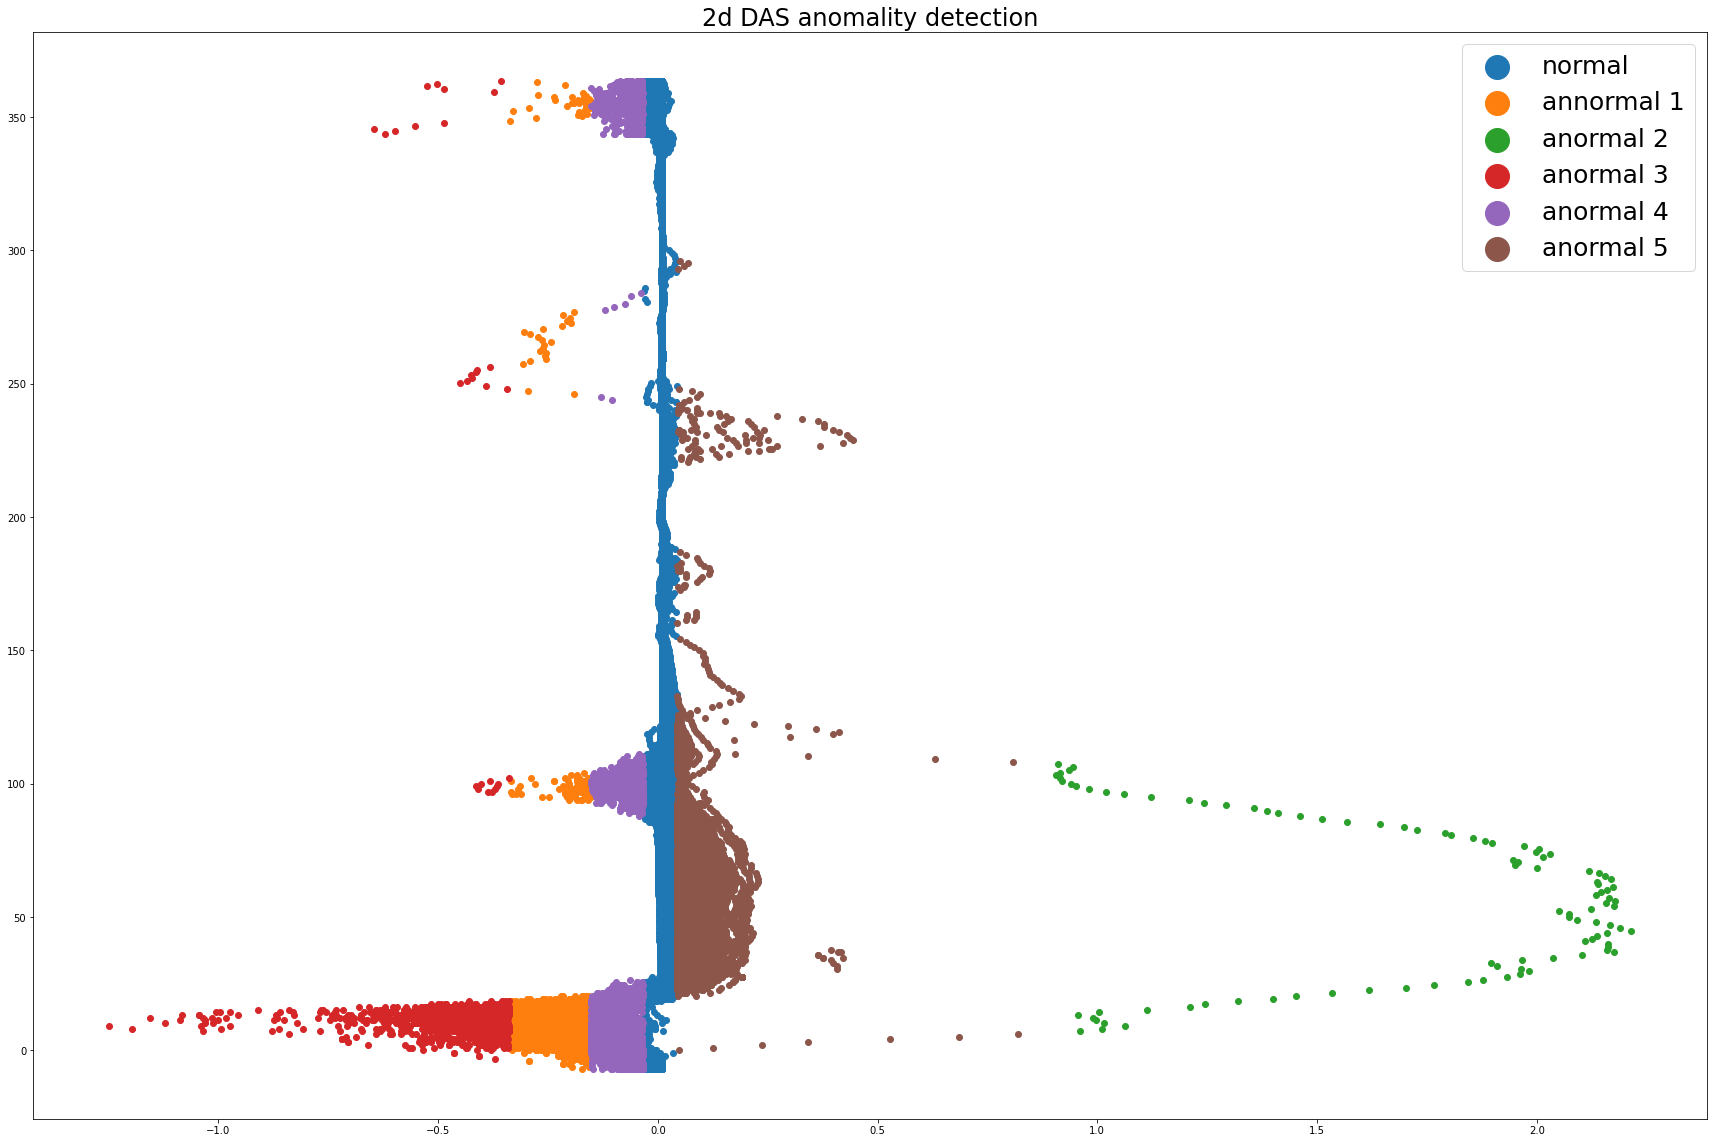

time: 2.81 s


In [72]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
model = KMeans(n_clusters=6,random_state=1230).fit(data_by_chanel[['c1']])
classes={0:'normal',
        1:'annormal 1',
        2: 'anormal 2',
        3:'anormal 3',
        4:'anormal 4',
        5:'anormal 5'}
fig, ax = plt.subplots(figsize=(30,20))
for g in np.unique(model.labels_):
    i = np.where(model.labels_ == g)
    ax.scatter(data_by_chanel.loc[i]['c1'],data_by_chanel.loc[i]['depth'], label=classes[g])
ax.legend(prop={'size': 25},markerscale=4)
plt.title('2d DAS anomality detection',fontsize=24)
plt.show()

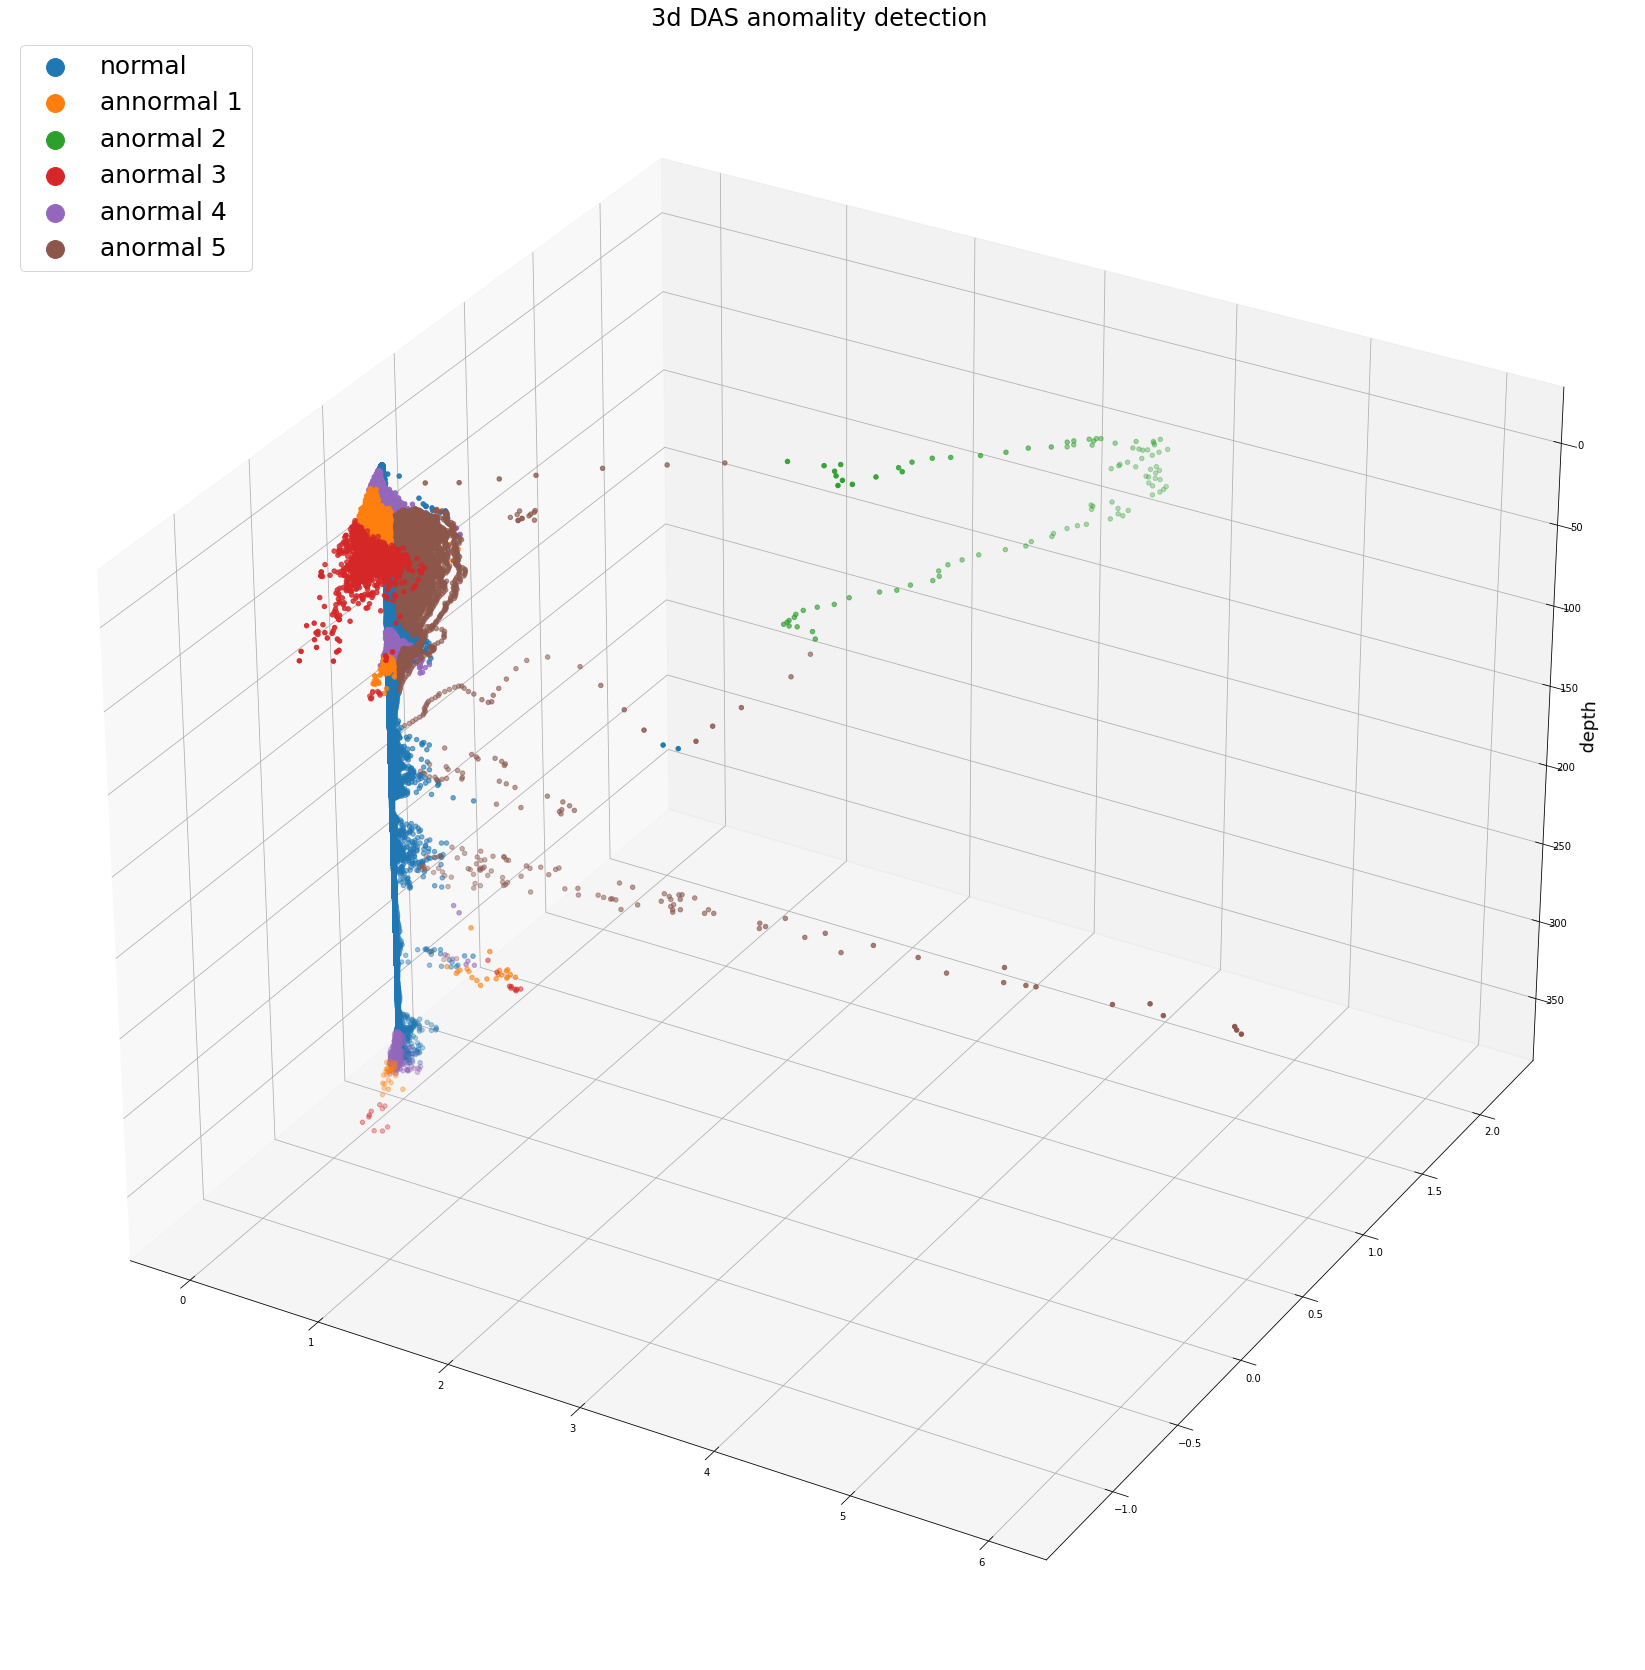

time: 3.01 s


In [73]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(projection='3d')
for g in np.unique(model.labels_):
    i = np.where(model.labels_ == g)
    ax.scatter(data_by_chanel.loc[i]['c0'],data_by_chanel.loc[i]['c1'],data_by_chanel.loc[i]['depth'], label=classes[g])
ax.legend(loc='upper left',prop={'size': 25},markerscale=4)
ax.set_zlabel('depth',fontsize=18)
ax.invert_zaxis()
plt.title('3d DAS anomality detection ',fontsize=24)
plt.show()

In [70]:
import plotly as py
import plotly.express as px
data_by_chanel['class']=model.labels_
data_by_chanel['class']=data_by_chanel['class'].apply(lambda x: classes[x])
fig = px.scatter(data_by_chanel, x='time',y='depth',color='class',
             size_max=2,template='gridon')
fig.update_layout(
    legend_title="please click on the colors bellew \nto filter points",
    title="distribution of DAS by time and depth",legend=dict(itemdoubleclick=False) )
fig.write_html('DAS-2d.html')

time: 4.13 s


In [71]:
import plotly as py
import plotly.express as px
fig = px.scatter_3d(data_by_chanel, x='time',y='c1',z='depth',color='class',
             size_max=2,template='gridon')
fig.update_scenes(zaxis_autorange="reversed")
fig.update_layout(
    legend_title="please click on the colors bellew \nto filter points",
    title="distribution of anomalities in DAS by time and depth",legend=dict(itemdoubleclick=False) )
fig.write_html('DAS-3d.html')

time: 4.16 s
